Fit a single model (used for the independent model)

In [2]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict

import os

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [3]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [26]:
# ----- EXPERIMENT HPARAMS -----
META_FEATURES   = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

# ----- DATA HPARAMS -----
OUT_DIR       = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC      = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH   = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

BATCH_SIZE  = 128
NUM_WORKERS = 4

MAX_DF = 0.7
MIN_DF = 20

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing
# ['formality','irony', 'sentences', 'punc_tags', 'pos_bigrams', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']
# NICK: Unsure which of of these features we should include!

# ----- TRAINING HPARAMS -----

LR = 1e-3
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

# ----- MODEL HPARAMS -----

NUM_TOPICS = 20
NUM_STYLES = 10
TOPIC_HIDDEN_DIM   = 128
STYLE_HIDDEN_DIM   = 16
DROPOUT    = 0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 1.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5.

STYLE_TOPIC_LINK = 'none'

NUM_EPOCHS = 30

DEVICE = torch.device('cuda:0')

# ----- CONFIG/SAVING -----
date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'topic_hidden_dim': TOPIC_HIDDEN_DIM,
    'style_hidden_dim': STYLE_HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'theta_prior_scale': THETA_PRIOR_SCALE,
    'kappa_prior_dist': KAPPA_PRIOR_DIST,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'kappa_prior_scale': KAPPA_PRIOR_SCALE,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'date': date,
    'lr': LR,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,
}

PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
os.makedirs(PATH, exist_ok=True)
with open(os.path.join(PATH, 'info.json'), 'w') as f:
    json.dump(info, f, indent=4)

# Data Setup 

## Data Preprocessing/Loading

In [27]:
if not os.path.exists(DATA_DIR_PATH):
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = prepare_data(DATA_SRC,
                 SYNTHETIC_SRC,
                 SPLITS_PATH,
                 META_FEATURES,
                 DATA_DIR_PATH,
                 max_df = MAX_DF,
                 min_df = MIN_DF)
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR_PATH)   

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.7_mindf20_DATA


In [28]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [29]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [30]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [31]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [32]:
train_test_batch = next(iter(dl))
for k, v in train_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])


In [33]:
eval_test_batch = next(iter(eval_dl))
for k, v in eval_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])
bow_h1         
	               : torch.Size([128, 3098])
bow_h2         
	               : torch.Size([128, 3098])


# Training

## Setup

In [34]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    topic_hidden = TOPIC_HIDDEN_DIM, style_hidden = STYLE_HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())
print(prod_slda.style_encoder.fc2.weight)


{'beta_topic': tensor([[-0.1390, -0.1769,  0.1962,  ...,  0.1805,  0.1970, -0.1647],
        [-0.1145, -0.2135,  0.1970,  ...,  0.1013, -0.1415, -0.0528],
        [-0.0026,  0.1317,  0.0016,  ..., -0.1518, -0.0941,  0.0538],
        ...,
        [-0.1735,  0.0038, -0.1879,  ...,  0.1490, -0.1439,  0.0075],
        [ 0.1689, -0.0975,  0.0712,  ...,  0.0549,  0.1598, -0.1547],
        [ 0.1072, -0.1586,  0.0668,  ...,  0.1902, -0.1642,  0.1775]])}
{'casing': tensor([[ 0.2489, -0.2175, -0.3087],
        [ 0.1845,  0.0787,  0.2793],
        [ 0.2424,  0.2629, -0.0665],
        [ 0.0009,  0.2277,  0.1243],
        [ 0.1666, -0.0240, -0.1311],
        [ 0.0376,  0.1133, -0.2463],
        [-0.2070, -0.2516,  0.0592],
        [-0.1730, -0.2752,  0.1795],
        [ 0.2563, -0.0630, -0.1708],
        [-0.1826, -0.2810, -0.1686]]), 'emoji_task': tensor([[ 0.2336,  0.1210,  0.1987, -0.2206, -0.2787, -0.0262,  0.2290,  0.2059,
         -0.1784,  0.0215, -0.1571,  0.1764, -0.1359, -0.0150, -0.1351, 

## Training 

In [35]:
%%capture cap --no-stderr
pyro.clear_param_store()
prod_slda.train()

In [36]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [37]:
LAST_ELBOS = 10

In [38]:
def train_epochs(prod_slda, svi, train_dl, eval_dl, num_epochs, device, last_elbos = 5):
    total_epochs = 0
    train_elbo = []
    val_elbo = []

    print("---TRAINING---")
    for epoch in range(num_epochs):

        epoch_elbo = 0.
        prod_slda.train()
        for batch in tqdm(train_dl):

            batch = batch_to_device(batch, device)

            bow = batch['bow']
            meta = batch['meta']

            epoch_elbo += svi.step(bow, meta)


        eval_elbo = 0
        prod_slda.eval()
        with torch.no_grad():
            for batch in tqdm(eval_dl):

                batch = batch_to_device(batch, device)

                bow = batch['bow']
                meta = batch['meta']

                eval_elbo += svi.evaluate_loss(bow, meta)           


        print(f'Epoch {epoch}: {epoch_elbo:.3f}')
        print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')

        train_elbo.append(epoch_elbo)
        val_elbo.append(eval_elbo)
        total_epochs +=1

        if len(val_elbo) > last_elbos:
            val_elbo_changes = [val_elbo[i] - val_elbo[i-1] for i in range(len(val_elbo) - last_elbos, len(val_elbo))]
            if np.mean(val_elbo_changes) > 0:
                print(f'Val ELBO diverging, stopping fitting: {np.mean(val_elbo_changes):.3f}')
                break 
                
    return train_elbo, val_elbo

In [39]:
train_elbo, val_elbo = train_epochs(prod_slda, svi, dl, eval_dl, NUM_EPOCHS, DEVICE, last_elbos = LAST_ELBOS) 

---TRAINING---


100%|██████████| 179/179 [00:07<00:00, 22.49it/s]


Epoch 0: 19532.873
Epoch 0: Eval: 5617.769


100%|██████████| 179/179 [00:07<00:00, 22.45it/s]


Epoch 1: 17910.722
Epoch 1: Eval: 5701.702


100%|██████████| 179/179 [00:07<00:00, 22.42it/s]


Epoch 2: 17348.276
Epoch 2: Eval: 5520.498


100%|██████████| 179/179 [00:07<00:00, 23.26it/s]


Epoch 3: 17085.313
Epoch 3: Eval: 5494.578


100%|██████████| 179/179 [00:07<00:00, 23.19it/s]


Epoch 4: 16938.410
Epoch 4: Eval: 5460.572


100%|██████████| 179/179 [00:07<00:00, 22.69it/s]


Epoch 5: 16851.136
Epoch 5: Eval: 5595.087


100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 6: 16742.933
Epoch 6: Eval: 5446.512


100%|██████████| 179/179 [00:08<00:00, 21.93it/s]


Epoch 7: 16688.300
Epoch 7: Eval: 5497.404


100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 8: 16654.720
Epoch 8: Eval: 5503.374


100%|██████████| 179/179 [00:07<00:00, 23.19it/s]


Epoch 9: 16517.082
Epoch 9: Eval: 5598.555


100%|██████████| 179/179 [00:07<00:00, 22.88it/s]


Epoch 10: 16458.506
Epoch 10: Eval: 5532.039


100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 11: 16480.153
Epoch 11: Eval: 5524.388


100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 12: 16433.703
Epoch 12: Eval: 5495.046


100%|██████████| 179/179 [00:07<00:00, 23.69it/s]

Epoch 13: 16417.234
Epoch 13: Eval: 5511.276
Val ELBO diverging, stopping fitting: 1.670


In [40]:
total_epochs = len(train_elbo)

In [41]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_21_07_02/model_epoch14_5511.27596282959.pt


In [42]:
pd.DataFrame({'train_elbo': train_elbo, 'val_elbo': val_elbo}).to_csv(os.path.join(PATH, 'elbos.json'), index = None)

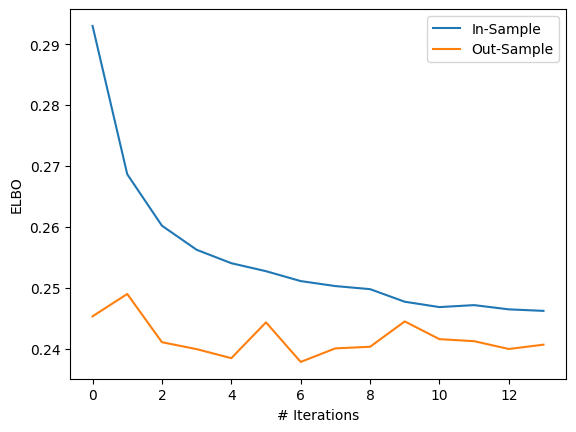

In [43]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig(os.path.join(PATH, 'loss_plot.png'), dpi = 600, facecolor = None)